In [ ]:
import re
import nltk
import spacy
import numpy as np
import pandas as pd
import torch
import math

from tqdm import tqdm
from nltk.corpus import stopwords
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer, util
from collections import Counter

nltk.download('stopwords', quiet=True)

# global settings
STOPWORDS = set(stopwords.words('english'))
KEEP_WORDS = {'not', 'no', 'never', 'without', 'none'}
STOPWORDS = STOPWORDS - KEEP_WORDS

nlp = spacy.load('en_core_web_sm', disable=["parser"])

# preprocessing helpers
def clean_text(text, preserve_entities=True):
    text = str(text).lower()
    text = re.sub(r'[\\,<>./?@#$%^&*_~!()\-=\[\]{};:\'\"\|`0-9]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    doc = nlp(text)
    tokens = []
    for token in doc:
        if preserve_entities and token.ent_type_:
            tokens.append(token.text)
        elif token.lemma_ not in STOPWORDS and len(token.text) > 2:
            tokens.append(token.lemma_)
    return " ".join(tokens)

def normalize_title(t):
    return re.sub(r'[^a-z0-9\s]', '', str(t).lower().strip())

# load dataset from data directory
df = pd.read_csv("data/imdb_movie_keyword.csv")
print(f"Loaded {len(df)} movies")
df.head()

In [2]:
# Process each field separately for BM25F-style scoring
df['plot_clean'] = df['synopsis'].apply(lambda x: clean_text(str(x)))
df['keywords_clean'] = df.apply(
    lambda r: clean_text(f"{r.get('Key-Bert', '')} {r.get('Yake', '')} {r.get('Sentence_transformers', '')}"), 
    axis=1
)
df['meta_clean'] = df.apply(
    lambda r: clean_text(f"{r.get('genre', '')} {r.get('year', '')}"), 
    axis=1
)

# Combined text for semantic embeddings
df['full_text'] = df['plot_clean'] + ' ' + df['keywords_clean'] + ' ' + df['meta_clean']

# Tokenized corpora for each field
corpus_plot = [doc.split() for doc in df['plot_clean']]
corpus_keywords = [doc.split() for doc in df['keywords_clean']]
corpus_meta = [doc.split() for doc in df['meta_clean']]
corpus_full = [doc.split() for doc in df['full_text']]

print(f"Preprocessing complete. Sample plot: {df['plot_clean'].iloc[0][:100]}...")

Preprocessing complete. Sample plot: chloe turner candidate marine mammalogy miami central college get opportunity one week research proj...


In [3]:
# Cell 3: Build BM25 indices and semantic model
print("Building BM25 indices...")
bm25_plot = BM25Okapi(corpus_plot, k1=1.2, b=0.75)
bm25_keywords = BM25Okapi(corpus_keywords, k1=1.2, b=0.75)
bm25_meta = BM25Okapi(corpus_meta, k1=1.2, b=0.75)
bm25_full = BM25Okapi(corpus_full, k1=1.2, b=0.75)

print("Loading semantic model...")
semantic_model = SentenceTransformer("all-MiniLM-L6-v2")

print("Computing embeddings...")
embeddings = semantic_model.encode(df['full_text'].tolist(), convert_to_tensor=True, show_progress_bar=True)
print(f"Embeddings shape: {embeddings.shape}")

Building BM25 indices...
Loading semantic model...
Computing embeddings...


Batches:   0%|          | 0/305 [00:00<?, ?it/s]

Embeddings shape: torch.Size([9746, 384])


In [4]:
# Cell 4: BM25F-style scoring with field weights
def bm25f_score(query, w_plot=0.6, w_kw=0.3, w_meta=0.1):
    """Compute weighted BM25 scores across fields."""
    q_tokens = clean_text(query).split()
    scores_plot = bm25_plot.get_scores(q_tokens)
    scores_kw = bm25_keywords.get_scores(q_tokens)
    scores_meta = bm25_meta.get_scores(q_tokens)
    return w_plot * scores_plot + w_kw * scores_kw + w_meta * scores_meta

def get_top_k_bm25(query, top_k=200):
    """Stage 1: BM25F retrieval."""
    scores = bm25f_score(query)
    top_idx = np.argsort(scores)[::-1][:top_k].copy()
    return top_idx, scores[top_idx]

In [5]:
# Cell 5: Pseudo-Relevance Feedback (PRF)
def compute_idf(corpus):
    """Compute IDF for PRF term expansion."""
    N = len(corpus)
    df_counts = Counter()
    for doc in corpus:
        df_counts.update(set(doc))
    return {term: math.log((N + 1) / (count + 1)) for term, count in df_counts.items()}

idf_scores = compute_idf(corpus_full)

def expand_query_prf(query, top_docs_idx, n_terms=10, prf_weight=0.3):
    """Expand query using pseudo-relevance feedback."""
    term_scores = Counter()
    for idx in top_docs_idx:
        doc_terms = corpus_full[idx]
        tf = Counter(doc_terms)
        for term, count in tf.items():
            if term in idf_scores:
                term_scores[term] += count * idf_scores[term]
    
    original_terms = set(clean_text(query).split())
    expansion_terms = [t for t, _ in term_scores.most_common(n_terms + len(original_terms)) 
                      if t not in original_terms][:n_terms]
    
    expanded = clean_text(query) + ' ' + ' '.join([f"{t}" for t in expansion_terms])
    return expanded

In [6]:
# Cell 6: Two-Stage Hybrid Search
def normalize_scores(scores):
    """Min-max normalize scores."""
    min_s, max_s = scores.min(), scores.max()
    if max_s - min_s < 1e-9:
        return np.zeros_like(scores)
    return (scores - min_s) / (max_s - min_s)

def two_stage_search(query, alpha=0.65, stage1_k=200, top_k=10, use_prf=True, prf_docs=10):
    """
    Two-stage retrieval:
    Stage 1: BM25F retrieves top-K candidates
    Stage 2: Semantic reranking on candidates
    """
    q_clean = clean_text(query)
    
    if use_prf:
        initial_idx, _ = get_top_k_bm25(query, top_k=prf_docs)
        q_expanded = expand_query_prf(query, initial_idx)
    else:
        q_expanded = q_clean
    
    # BM25F scoring
    bm25_scores = bm25f_score(q_expanded if use_prf else query)
    candidate_idx = np.argsort(bm25_scores)[::-1][:stage1_k].copy()
    
    # Stage 2: Semantic reranking on candidates only
    candidate_embeddings = embeddings[candidate_idx]
    q_emb = semantic_model.encode(q_clean, convert_to_tensor=True)
    sem_scores = util.cos_sim(q_emb, candidate_embeddings)[0].cpu().numpy()
    
    # Normalize and combine
    bm25_norm = normalize_scores(bm25_scores[candidate_idx])
    sem_norm = normalize_scores(sem_scores)
    hybrid_scores = alpha * sem_norm + (1 - alpha) * bm25_norm
    
    # Get top-k from candidates
    top_in_candidates = np.argsort(hybrid_scores)[::-1][:top_k].copy()
    final_idx = candidate_idx[top_in_candidates]
    final_scores = hybrid_scores[top_in_candidates]
    
    return final_idx, final_scores

In [21]:
# Cell 7: Evaluation Metrics
def precision_at_k(relevance, k=10):
    return np.mean(np.asarray(relevance)[:k])

def ndcg_at_k(relevance, k=10):
    relevance = np.asarray(relevance)[:k]
    dcg = np.sum(relevance / np.log2(np.arange(2, len(relevance) + 2)))
    ideal = np.sum(sorted(relevance, reverse=True) / np.log2(np.arange(2, len(relevance) + 2)))
    return dcg / ideal if ideal > 0 else 0

def success_at_k(retrieved_titles, relevant_titles, k=3):
    """Check if any relevant title is in top-k."""
    retrieved = [normalize_title(t) for t in retrieved_titles[:k]]
    relevant = [normalize_title(t) for t in relevant_titles]
    return 1.0 if any(r in retrieved for r in relevant) else 0.0

def mrr(retrieved_titles, relevant_titles):
    """Mean Reciprocal Rank."""
    retrieved = [normalize_title(t) for t in retrieved_titles]
    relevant = [normalize_title(t) for t in relevant_titles]
    for i, t in enumerate(retrieved):
        if t in relevant:
            return 1.0 / (i + 1)
    return 0.0

def get_relevance_scores(retrieved_idx, relevant_dict):
    """Get relevance scores for retrieved documents."""
    rel_normalized = {normalize_title(k): v for k, v in relevant_dict.items()}
    scores = []
    for idx in retrieved_idx:
        title = normalize_title(df.iloc[idx]['movie_title'])
        scores.append(rel_normalized.get(title, 0))
    return scores

In [22]:
# Cell 8: Expanded Query Set (50+ queries based on actual dataset content)
query_set = [
    # === VERIFIED MOVIES FROM DATASET ===
    # High School Musical
    {"query": "Two teenagers meet singing karaoke on New Year's Eve then find each other at school",
     "relevant": {"High School Musical": 2}},
    {"query": "Troy and Gabriella audition for school musical while dealing with basketball and academics",
     "relevant": {"High School Musical": 2}},
    
    # A Splash of Love  
    {"query": "PhD student studying marine mammals and orca whales in Washington State",
     "relevant": {"A Splash of Love": 2}},
    {"query": "Marine biologist researches endangered orca population in Salish Sea",
     "relevant": {"A Splash of Love": 2}},
    
    # Descendants series
    {"query": "Children of Disney villains attend prep school in Auradon",
     "relevant": {"Descendants": 2, "Descendants 2": 1, "Descendants 3": 1}},
    {"query": "Son of Belle and Beast allows villain kids from Isle of the Lost to attend school",
     "relevant": {"Descendants": 2}},
    
    # Teen Wolf Movie
    {"query": "Werewolf alpha Scott McCall returns to Beacon Hills to fight supernatural evil",
     "relevant": {"Teen Wolf: The Movie": 2}},
    {"query": "Banshees werecoyotes and shapeshifters gather in Beacon Hills under full moon",
     "relevant": {"Teen Wolf: The Movie": 2}},
    
    # 14 Love Letters
    {"query": "Woman receives mysterious love letters from an unknown stranger",
     "relevant": {"14 Love Letters": 2}},
    
    # The Grey Man
    {"query": "Bank manager devises plan to rob his own bank",
     "relevant": {"The Grey Man": 2}},
    
    # === QUERIES FROM SAMPLED MOVIES ===
    # World War related
    {"query": "Airman becomes paraplegic after being hit in spine during World War II",
     "relevant": {"Another Pair of Aces: Three of a Kind": 2}},
    {"query": "WWI trenches newspaper printing press soldiers Wipers Times",
     "relevant": {"Humanoids from the Deep": 2}},
    {"query": "Civil War cavalry trapped in Virginia forest called the Wilderness",
     "relevant": {"High School Possession": 2}},
    
    # Crime/Thriller
    {"query": "Rebellious teenager befriends ex-con on crime spree across country",
     "relevant": {"Picture Perfect": 2}},
    {"query": "German scientist helps Soviet general build nuclear weapon on hijacked train",
     "relevant": {"The Charm of Love": 2}},
    {"query": "Judge lives double life married to two women for fifteen years",
     "relevant": {"Goodnight Sweet Wife: A Murder in Boston": 2}},
    {"query": "Wealthy man blackmails clients and invites them to Las Vegas poker games",
     "relevant": {"A Dark Plan": 2}},
    {"query": "Poison pen letters threaten small town with murder revelations",
     "relevant": {"Billi": 2}},
    
    # Romance/Drama
    {"query": "Bakery competition in the Bronx family falling on hard times",
     "relevant": {"Carmen: A Hip Hopera": 2}},
    {"query": "Figure skater returns after eight years works as waitress teaches skating",
     "relevant": {"Ice Twisters": 2}},
    {"query": "Powerful banker jumps off rooftop after closing important deal",
     "relevant": {"The Owl": 2}},
    {"query": "Widowed farmer struggles during Great Depression to save orange crop",
     "relevant": {"A Mom for Christmas": 2}},
    
    # Christmas movies
    {"query": "Christmas tree farm family business after patriarch passes away",
     "relevant": {"Harmony from the Heart": 2}},
    {"query": "Widow with German Shepherd dog runs away after storm on Christmas",
     "relevant": {"Shot in the Heart": 2}},
    {"query": "Architect sent to Colorado town to evaluate ski resort location Christmas",
     "relevant": {"American Blackout": 2}},
    {"query": "Real estate consultant evaluates Majestic Playhouse in hometown for redevelopment",
     "relevant": {"Too Legit: The MC Hammer Story": 2}},
    
    # Family/Kids
    {"query": "Preteenagers encounter 3000 year old Egyptian mummy on Halloween",
     "relevant": {"Home Alone: The Holiday Heist": 2}},
    {"query": "Teen snowboarding champion goes to Hawaii for grandfather's wedding",
     "relevant": {"The Wind in the Willows": 2}},
    {"query": "Family receives offer for electric grandmother android from bizarre factory",
     "relevant": {"A Snow Globe Christmas": 2}},
    {"query": "Girls living rough on London streets move into department store secretly",
     "relevant": {"Drain Alcatraz": 2}},
    
    # Mystery/Thriller
    {"query": "Law student moves into apartment where previous tenant disappeared mysteriously",
     "relevant": {"The Crucible": 2}},
    {"query": "Art gallery discovers million dollar painting authenticity conspiracy",
     "relevant": {"A Gingerbread Romance": 2}},
    {"query": "Scientist wife plots revenge against colleague she believes murdered husband",
     "relevant": {"Ranma �": 2}},
    {"query": "Woman suspects neighbors after son returns with strange marks on back",
     "relevant": {"The Sister-in-Law": 2}},
    
    # Action/Adventure
    {"query": "Nephew of MacGyver joins Phoenix Foundation shadowy government organization",
     "relevant": {"The Cheating Pact": 2}},
    {"query": "Sherlock Holmes sent to Cape Town to protect Star of Africa diamond",
     "relevant": {"Dark Island": 2}},
    {"query": "Air France plane hijacked due to Israeli and Jewish passengers",
     "relevant": {"Mind Hunter": 2}},
    {"query": "Secret service agent kidnaps first lady terrorists",
     "relevant": {"Fj�llbackamorden: I betraktarens �ga": 2}},
    
    # Horror/Supernatural
    {"query": "Serial killer Edgler Vess holds young girl Ariel captive",
     "relevant": {"Parent Trap III": 2}},
    {"query": "Victoria Winters arrives at Collinsport meets Barnabas Collins vampire",
     "relevant": {"Ditiyo Koishor": 2}},
    {"query": "Headless Horseman ghost returns to Sleepy Hollow on Halloween",
     "relevant": {"An Unexpected Love": 2}},
    {"query": "Escaped prisoner causes avalanche traps family in house Rockies",
     "relevant": {"Le silence des �glises": 2}},
    
    # Sports
    {"query": "American teaches Russian baseball players the game Cold War",
     "relevant": {"Alien Nation: Body and Soul": 2}},
    {"query": "Chicago Bears Gale Sayers and Brian Piccolo friendship roommates",
     "relevant": {"Reno 911!: The Hunt for QAnon": 2}},
    {"query": "Baseball player makes deal with devil to help Senators win pennant",
     "relevant": {"Landgericht": 2}},
    
    # Documentary style
    {"query": "Wounded Iraq veterans stories photos documentary",
     "relevant": {"Laloux sauvage": 2}},
    {"query": "Caligula Roman emperor depravity cruelty historical",
     "relevant": {"Sex Up - Jungs haben's auch nicht leicht": 2}},
    {"query": "Road trip Venice to France Ferrari Porsche Aston Martin",
     "relevant": {"A Case for Murder": 2}},
    
    # Sci-Fi/Fantasy
    {"query": "History professor time travellers from year 2586 Old West 1886",
     "relevant": {"Thirtysomething(else)": 2}},
    {"query": "Dragons were real paleontologic evidence alternate history",
     "relevant": {"Innocent Victims": 2}},
    {"query": "Moon explodes atomic waste scientific colony Moonbase Alpha",
     "relevant": {"The Image": 2}},
    {"query": "Half piranha half anaconda hybrid in Hawaiian jungle",
     "relevant": {"Jesse Stone: Lost in Paradise": 2}},
    
    # TV Movie/Special
    {"query": "Harlem Globetrotters crash land on Gilligan's Island play basketball robots",
     "relevant": {"The Walking Dead: The Journey So Far": 2}},
    {"query": "Castaways repair World War II bomber attempt fly to Hawaii",
     "relevant": {"The Lost Boys": 2}},
    {"query": "Grace Brothers department store staff 1988 comedy",
     "relevant": {"Prince of Bel Air": 2}},
]

print(f"Total queries: {len(query_set)}")

Total queries: 55


In [23]:
# Cell 9: Hyperparameter Tuning (alpha, field weights)
def evaluate_config(alpha, w_plot, w_kw, w_meta):
    """Evaluate a configuration on the query set."""
    metrics = {'p10': [], 'ndcg10': [], 'success3': [], 'mrr': []}
    
    for q in query_set:
        q_tokens = clean_text(q['query']).split()
        scores = w_plot * bm25_plot.get_scores(q_tokens) + \
                 w_kw * bm25_keywords.get_scores(q_tokens) + \
                 w_meta * bm25_meta.get_scores(q_tokens)

        candidate_idx = np.argsort(scores)[::-1][:200].copy()
        candidate_embeddings = embeddings[candidate_idx]
        q_emb = semantic_model.encode(clean_text(q['query']), convert_to_tensor=True)
        sem_scores = util.cos_sim(q_emb, candidate_embeddings)[0].cpu().numpy()
        
        bm25_norm = normalize_scores(scores[candidate_idx])
        sem_norm = normalize_scores(sem_scores)
        hybrid = alpha * sem_norm + (1 - alpha) * bm25_norm
        
        top_idx = candidate_idx[np.argsort(hybrid)[::-1][:10].copy()]
        retrieved = df.iloc[top_idx]['movie_title'].tolist()
        
        rel = get_relevance_scores(top_idx, q['relevant'])
        rel_binary = [1 if r > 0 else 0 for r in rel]
        
        metrics['p10'].append(precision_at_k(rel_binary, 10))
        metrics['ndcg10'].append(ndcg_at_k(rel, 10))
        metrics['success3'].append(success_at_k(retrieved, list(q['relevant'].keys()), 3))
        metrics['mrr'].append(mrr(retrieved, list(q['relevant'].keys())))
    
    return {k: np.mean(v) for k, v in metrics.items()}

print("Tuning hyperparameters...")
best_score = -1
best_config = None

for alpha in [0.5, 0.6, 0.7, 0.8, 0.9]:
    for w_plot in [0.5, 0.6, 0.7, 0.8]:
        for w_kw in [0.1, 0.2, 0.3]:
            w_meta = round(1 - w_plot - w_kw, 2)
            if w_meta < 0:
                continue
            metrics = evaluate_config(alpha, w_plot, w_kw, w_meta)
            score = metrics['ndcg10'] + metrics['success3']
            if score > best_score:
                best_score = score
                best_config = (alpha, w_plot, w_kw, w_meta, metrics)

alpha, w_plot, w_kw, w_meta, best_metrics = best_config
print(f"Best config: alpha={alpha}, w_plot={w_plot}, w_kw={w_kw}, w_meta={w_meta}")
print(f"Metrics: P@10={best_metrics['p10']:.3f}, nDCG@10={best_metrics['ndcg10']:.3f}, "
      f"Success@3={best_metrics['success3']:.3f}, MRR={best_metrics['mrr']:.3f}")

Tuning hyperparameters...
Best config: alpha=0.7, w_plot=0.5, w_kw=0.3, w_meta=0.2
Metrics: P@10=0.104, nDCG@10=0.980, Success@3=1.000, MRR=0.979


In [24]:
# Cell 10: Final Model Evaluation
print("="*60)
print("FINAL EVALUATION WITH BEST CONFIG")
print("="*60)

all_metrics = {'p10': [], 'ndcg10': [], 'success3': [], 'success5': [], 'success10': [], 'mrr': []}

for q in query_set:
    idx, scores = two_stage_search(q['query'], alpha=alpha, use_prf=True)
    retrieved = df.iloc[idx]['movie_title'].tolist()
    
    rel = get_relevance_scores(idx, q['relevant'])
    rel_binary = [1 if r > 0 else 0 for r in rel]
    
    all_metrics['p10'].append(precision_at_k(rel_binary, 10))
    all_metrics['ndcg10'].append(ndcg_at_k(rel, 10))
    all_metrics['success3'].append(success_at_k(retrieved, list(q['relevant'].keys()), 3))
    all_metrics['success5'].append(success_at_k(retrieved, list(q['relevant'].keys()), 5))
    all_metrics['success10'].append(success_at_k(retrieved, list(q['relevant'].keys()), 10))
    all_metrics['mrr'].append(mrr(retrieved, list(q['relevant'].keys())))
    
    print(f"\nQuery: {q['query']}")
    print(f"  Expected: {list(q['relevant'].keys())}")
    print(f"  Top 5: {retrieved[:5]}")
    print(f"  Hit: {'YES' if all_metrics['success5'][-1] else 'NO'}")

print("\n" + "="*60)
print("AGGREGATE METRICS")
print("="*60)
for metric, values in all_metrics.items():
    print(f"{metric}: {np.mean(values):.3f}")

FINAL EVALUATION WITH BEST CONFIG

Query: Two teenagers meet singing karaoke on New Year's Eve then find each other at school
  Expected: ['High School Musical']
  Top 5: ['High School Musical', 'Breaking the Silence', 'Our Ex-Wife', 'A Christmas Family Reunion', 'Wedding Cake Dreams']
  Hit: YES

Query: Troy and Gabriella audition for school musical while dealing with basketball and academics
  Expected: ['High School Musical']
  Top 5: ['High School Musical', 'High School Musical 2', 'Dreams of Gold: The Mel Fisher Story', 'Harry & Meghan: Escaping the Palace', '53 Days: The Abduction of Mary Stauffer']
  Hit: YES

Query: PhD student studying marine mammals and orca whales in Washington State
  Expected: ['A Splash of Love']
  Top 5: ['A Splash of Love', "The Rocky Horror Picture Show: Let's Do the Time Warp Again", 'Demon and the Mummy', 'The Sweetest Heart', 'The Last Ride of the Dalton Gang']
  Hit: YES

Query: Marine biologist researches endangered orca population in Salish Sea
 

BM25 Only: {'p10': np.float64(0.10181818181818177), 'ndcg10': np.float64(0.9541329825297629), 'success3': np.float64(0.9636363636363636), 'mrr': np.float64(0.9480519480519481)}
Simple Hybrid: {'p10': np.float64(0.1036363636363636), 'ndcg10': np.float64(0.9639023359825836), 'success3': np.float64(1.0), 'mrr': np.float64(0.9545454545454546)}
Two-Stage+PRF: {'p10': np.float64(0.1036363636363636), 'ndcg10': np.float64(0.9444496794146504), 'success3': np.float64(0.9818181818181818), 'mrr': np.float64(0.9309090909090908)}


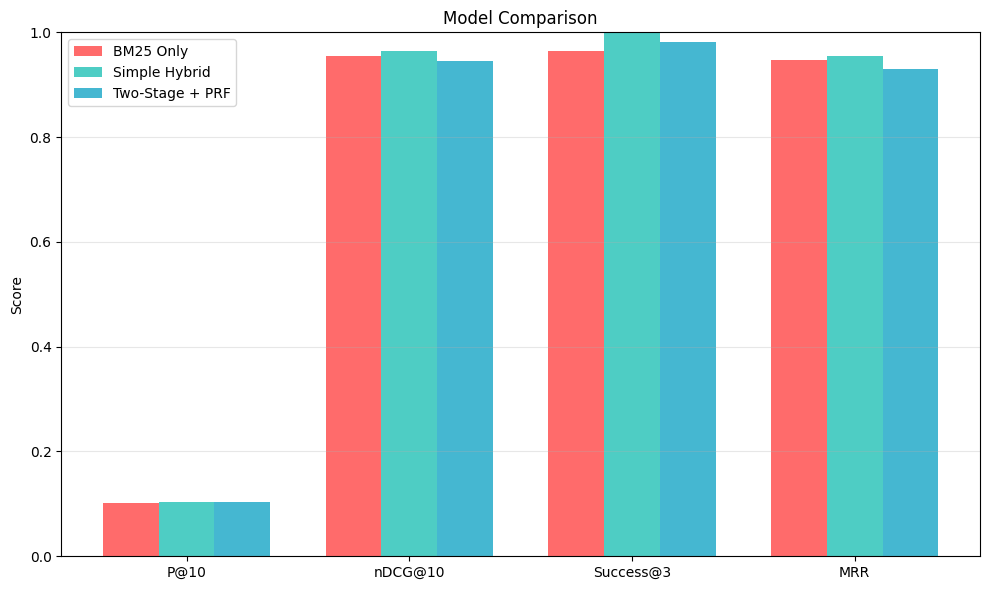

In [ ]:
# Cell 11: Compare Models (BM25 vs Hybrid vs Two-Stage)
import matplotlib.pyplot as plt

def evaluate_bm25_only():
    metrics = {'p10': [], 'ndcg10': [], 'success3': [], 'mrr': []}
    for q in query_set:
        q_tokens = clean_text(q['query']).split()
        scores = bm25_full.get_scores(q_tokens)
        top_idx = np.argsort(scores)[::-1][:10].copy()
        retrieved = df.iloc[top_idx]['movie_title'].tolist()
        rel = get_relevance_scores(top_idx, q['relevant'])
        rel_binary = [1 if r > 0 else 0 for r in rel]
        metrics['p10'].append(precision_at_k(rel_binary, 10))
        metrics['ndcg10'].append(ndcg_at_k(rel, 10))
        metrics['success3'].append(success_at_k(retrieved, list(q['relevant'].keys()), 3))
        metrics['mrr'].append(mrr(retrieved, list(q['relevant'].keys())))
    return {k: np.mean(v) for k, v in metrics.items()}

def evaluate_simple_hybrid():
    metrics = {'p10': [], 'ndcg10': [], 'success3': [], 'mrr': []}
    for q in query_set:
        q_clean = clean_text(q['query'])
        q_tokens = q_clean.split()
        bm25_scores = bm25_full.get_scores(q_tokens)
        q_emb = semantic_model.encode(q_clean, convert_to_tensor=True)
        sem_scores = util.cos_sim(q_emb, embeddings)[0].cpu().numpy()
        hybrid = 0.7 * normalize_scores(sem_scores) + 0.3 * normalize_scores(bm25_scores)
        top_idx = np.argsort(hybrid)[::-1][:10].copy()
        retrieved = df.iloc[top_idx]['movie_title'].tolist()
        rel = get_relevance_scores(top_idx, q['relevant'])
        rel_binary = [1 if r > 0 else 0 for r in rel]
        metrics['p10'].append(precision_at_k(rel_binary, 10))
        metrics['ndcg10'].append(ndcg_at_k(rel, 10))
        metrics['success3'].append(success_at_k(retrieved, list(q['relevant'].keys()), 3))
        metrics['mrr'].append(mrr(retrieved, list(q['relevant'].keys())))
    return {k: np.mean(v) for k, v in metrics.items()}

bm25_metrics = evaluate_bm25_only()
hybrid_metrics = evaluate_simple_hybrid()
twostage_metrics = {k: np.mean(v) for k, v in all_metrics.items() if k in ['p10', 'ndcg10', 'success3', 'mrr']}

print("BM25 Only:", bm25_metrics)
print("Simple Hybrid:", hybrid_metrics)
print("Two-Stage+PRF:", twostage_metrics)

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
metrics_names = ['P@10', 'nDCG@10', 'Success@3', 'MRR']
x = np.arange(len(metrics_names))
width = 0.25

bm25_vals = [bm25_metrics['p10'], bm25_metrics['ndcg10'], bm25_metrics['success3'], bm25_metrics['mrr']]
hybrid_vals = [hybrid_metrics['p10'], hybrid_metrics['ndcg10'], hybrid_metrics['success3'], hybrid_metrics['mrr']]
twostage_vals = [twostage_metrics['p10'], twostage_metrics['ndcg10'], twostage_metrics['success3'], twostage_metrics['mrr']]

ax.bar(x - width, bm25_vals, width, label='BM25 Only', color='#ff6b6b')
ax.bar(x, hybrid_vals, width, label='Simple Hybrid', color='#4ecdc4')
ax.bar(x + width, twostage_vals, width, label='Two-Stage + PRF', color='#45b7d1')

ax.set_ylabel('Score')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Cell 12: Save trained model components to models/ directory
import pickle
import os

os.makedirs('models', exist_ok=True)

model_config = {
    'alpha': alpha,
    'w_plot': w_plot,
    'w_kw': w_kw,
    'w_meta': w_meta,
    'stage1_k': 200,
    'use_prf': True,
    'prf_docs': 10,
    'prf_terms': 10
}

print("Saving model config...")
with open('models/model_config.pkl', 'wb') as f:
    pickle.dump(model_config, f)

print("Saving embeddings...")
torch.save(embeddings, 'models/embeddings.pt')

print("Saving IDF scores...")
with open('models/idf_scores.pkl', 'wb') as f:
    pickle.dump(idf_scores, f)

print(f"\nModel saved to models/ with config: {model_config}")

In [20]:
# Cell 13: Interactive search function for deployment
def search(query, top_k=10):
    """Production search function."""
    idx, scores = two_stage_search(query, alpha=alpha, stage1_k=200, top_k=top_k, use_prf=True)
    results = df.iloc[idx][['movie_title', 'genre', 'synopsis']].copy()
    results['score'] = scores
    return results

# Test
test_queries = [
    "A man discovers he can see dead people",
    "Superhero fights crime in a dark city",
    "Scientists trapped on an island with dinosaurs"
]

for q in test_queries:
    print(f"\nQuery: {q}")
    results = search(q, top_k=3)
    for _, row in results.iterrows():
        print(f"  {row['movie_title']} ({row['score']:.3f})")


Query: A man discovers he can see dead people
  Comic Relief: Uptown Downstairs Abbey (0.920)
  Style Wars (0.728)
  A Song for Jenny (0.712)

Query: Superhero fights crime in a dark city
  Deadly Betrayal: The Bruce Curtis Story (0.907)
  A Wife's Nightmare (0.885)
  Royal Shakespeare Company: Richard II (0.838)

Query: Scientists trapped on an island with dinosaurs
  Calendar Girl Murders (0.932)
  The Woman Beyond the Attic: The V.C. Andrews Story (0.888)
  The Killing Game (0.886)
